## CITE-Seq analysis
(adapted from [Processing and integrating 5k PBMCs CITE-seq data by Danila Bredikhin](https://muon-tutorials.readthedocs.io/en/latest/cite-seq/1-CITE-seq-PBMC-5k.html))

- Data availability: [Atlas of Human Breast Cancers](https://singlecell.broadinstitute.org/single_cell/study/SCP1039/a-single-cell-and-spatially-resolved-atlas-of-human-breast-cancers#/)

In [5]:
import os
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
msi_output = pd.read_csv("msisensor_pipeline/msisensor_output.csv")
msi_output.set_index('sample_id', inplace=True)

In [13]:
# Data loading
rna_data_path = "data/SCP1039/expression"
rna = sc.read_10x_mtx(rna_data_path)

The following code block merely does some data wrangling to parse out our patient of interest from the massive 100K dataset
We make a mask of the original dataframe for downstream analysis.

In [16]:
rna_adata = rna.copy()

# patient barcodes are in obs_names followed by cell barcode
rna_adata.obs['patient'] = rna_adata.obs_names.str.split('_').str[0]
rna_adata.obs['cell_bc'] = rna_adata.obs_names
print("Unique patients:", rna_adata.obs['patient'].unique())

# patients of interest
patient = ["CID3586", "CID3838", "CDI3921", "CID3941", "CID3946", "CID3948", "CID3963"]
patient_mask = rna_adata.obs['patient'].isin(patient)
assert msi_output.index.isin(rna_adata.obs_names).all(), "ID Mismatch!"

masked = rna_adata[patient_mask]
merged_obs = masked.obs.merge(
    msi_output,
    left_on='cell_bc',
    right_index=True,
    how='left'
)

# Update AnnData object
masked.obs = merged_obs
print(masked.obs)

Unique patients: ['CID3586' 'CID3921' 'CID45171' 'CID3838' 'CID4066' 'CID44041' 'CID4465'
 'CID4495' 'CID44971' 'CID44991' 'CID4513' 'CID4515' 'CID4523' 'CID3946'
 'CID3963' 'CID4461' 'CID4463' 'CID4471' 'CID4530N' 'CID4535' 'CID4040'
 'CID3941' 'CID3948' 'CID4067' 'CID4290A' 'CID4398']
                          patient                   cell_bc msi_status  \
CID3586_AAGACCTCAGCATGAG  CID3586  CID3586_AAGACCTCAGCATGAG        MSS   
CID3586_AAGGTTCGTAGTACCT  CID3586  CID3586_AAGGTTCGTAGTACCT        MSS   
CID3586_ACCAGTAGTTGTGGCC  CID3586  CID3586_ACCAGTAGTTGTGGCC        MSS   
CID3586_ACCCACTAGATGTCGG  CID3586  CID3586_ACCCACTAGATGTCGG        MSS   
CID3586_ACTGATGGTCAACTGT  CID3586  CID3586_ACTGATGGTCAACTGT        MSS   
...                           ...                       ...        ...   
CID3948_TTCGGTCTCTTCGAGA  CID3948  CID3948_TTCGGTCTCTTCGAGA      MSI-H   
CID3948_TTCTTAGGTGTCGCTG  CID3948  CID3948_TTCTTAGGTGTCGCTG      MSI-H   
CID3948_TTGCGTCGTGCACCAC  CID3948  CID3948_TTG

The following code performs QC and clustering on the masked dataset
1. first we filter genes that do not contain at least 10 cells
2. Then we normalize the total genes and perform log1p scaling
3. Then we filter the genes that are highly variable in the subset
4. This subset of data is used to perform dimensionality reduction and leiden clustering

In [17]:
patient_filtered = masked.copy()

# preprocessing and qc
sc.pp.calculate_qc_metrics(patient_filtered, inplace = True)
sc.pp.filter_genes(patient_filtered, min_cells = 10)
sc.pp.normalize_total(patient_filtered, target_sum = 1e4)
sc.pp.log1p(patient_filtered)

# filtering highly variable genes
sc.pp.highly_variable_genes(patient_filtered, n_top_genes = 2000)
rna_hvg = patient_filtered[:, patient_filtered.var.highly_variable]
sc.pp.scale(rna_hvg, max_value = 10)

# dimensionality reduction
sc.pp.pca(rna_hvg, n_comps = 50)
sc.pp.neighbors(rna_hvg, n_neighbors = 12, n_pcs = 30)

# clustering
sc.tl.leiden(rna_hvg, resolution = 0.5, flavor = "igraph", n_iterations = 2)
sc.tl.umap(rna_hvg)

# copy back to dataset
patient_filtered.obs['leiden'] = rna_hvg.obs['leiden']

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/anaconda3/envs/cite_seq/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


The following code ranks the gene groups and generates a heatmap based on the cluster grouping and differential expression.
Key points:
- We use the `pts=True` function in the `rank_gene_groups` to calculate percentage of cells expressing the genes.
- We use the `tie_correct=True` function to gain more accurate p-values for expression enrichment.

/opt/anaconda3/envs/cite_seq/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/opt/anaconda3/envs/cite_seq/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/opt/anaconda3/envs/cite_seq/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:440: PerformanceWarning: DataF

/opt/anaconda3/envs/cite_seq/lib/python3.11/site-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 19512 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


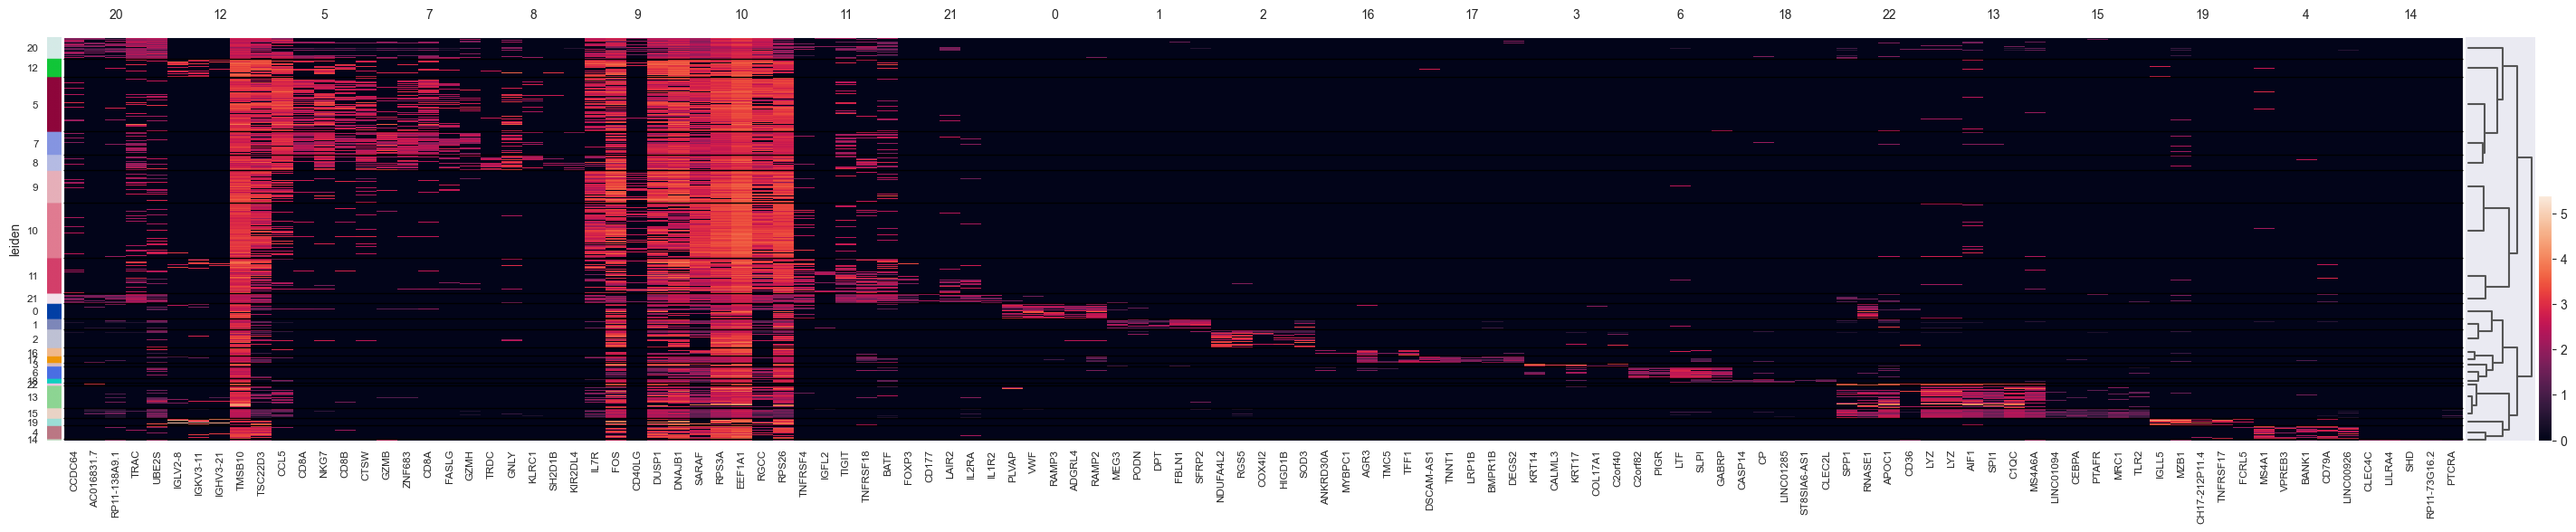

In [18]:
rna_filtered = patient_filtered.copy()

# explicitly use raw or log-normal data. helps with the scaling
if 'raw' in rna_filtered.__dict__ and rna_filtered.raw is not None:
    rna_for_de = rna_filtered
    use_raw = True
else:
    rna_for_de = rna_filtered
    use_raw = False

# rank gene groups.
sc.tl.rank_genes_groups(rna_for_de, 'leiden',
                        method = 'wilcoxon',
                        use_raw = use_raw,
                        pts = True,
                        tie_correct = True)

sc.pl.rank_genes_groups_heatmap(rna_for_de, n_genes = 5,
                                groupby = 'leiden',
                                show_gene_labels = True,
                                dendrogram = True)

<Figure size 1200x1000 with 0 Axes>

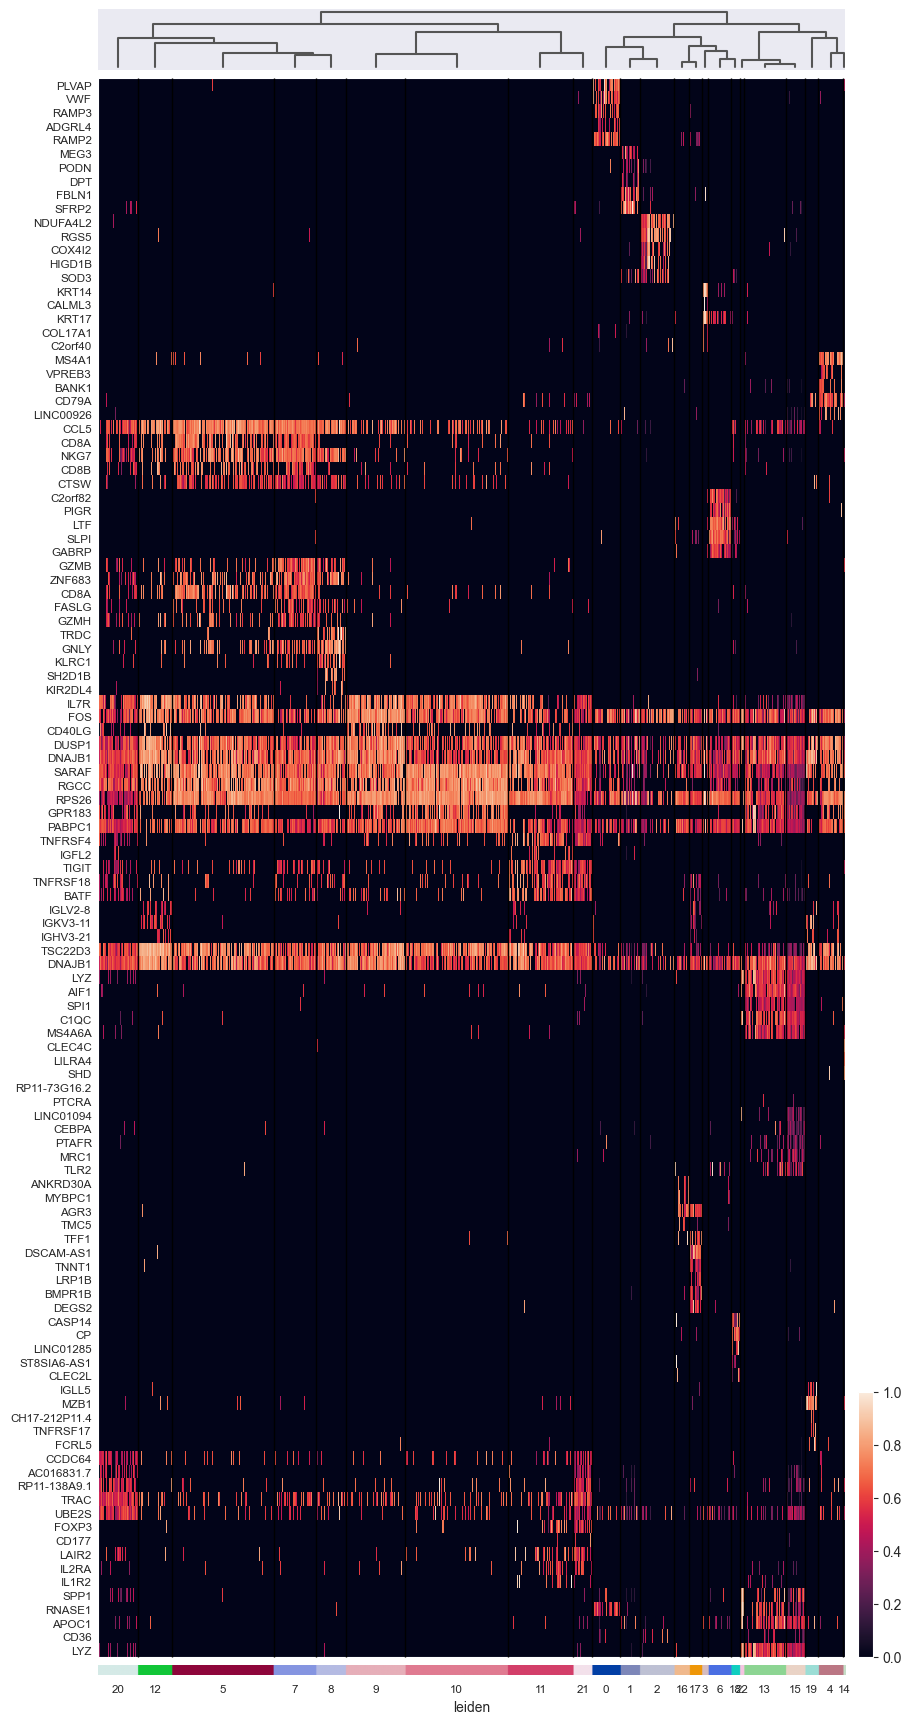

In [19]:
marker_genes = []
for i in range(len(rna_filtered.obs['leiden'].cat.categories)):
    markers_df = sc.get.rank_genes_groups_df(rna_for_de, group = str(i))
    filtered_markers = markers_df[(markers_df['pvals_adj'] < 0.05) &
                                  (markers_df['logfoldchanges'].abs() > 1)]
    if not filtered_markers.empty:
        marker_genes.extend(filtered_markers['names'][:5].tolist())  # Top 5 genes per cluster

# marker gene heatmap
if marker_genes:
    plt.figure(figsize = (12, 10))
    sc.pl.heatmap(rna_filtered, marker_genes, groupby = 'leiden',
                  dendrogram = True, standard_scale = 'var',
                  swap_axes = True, show_gene_labels = True)


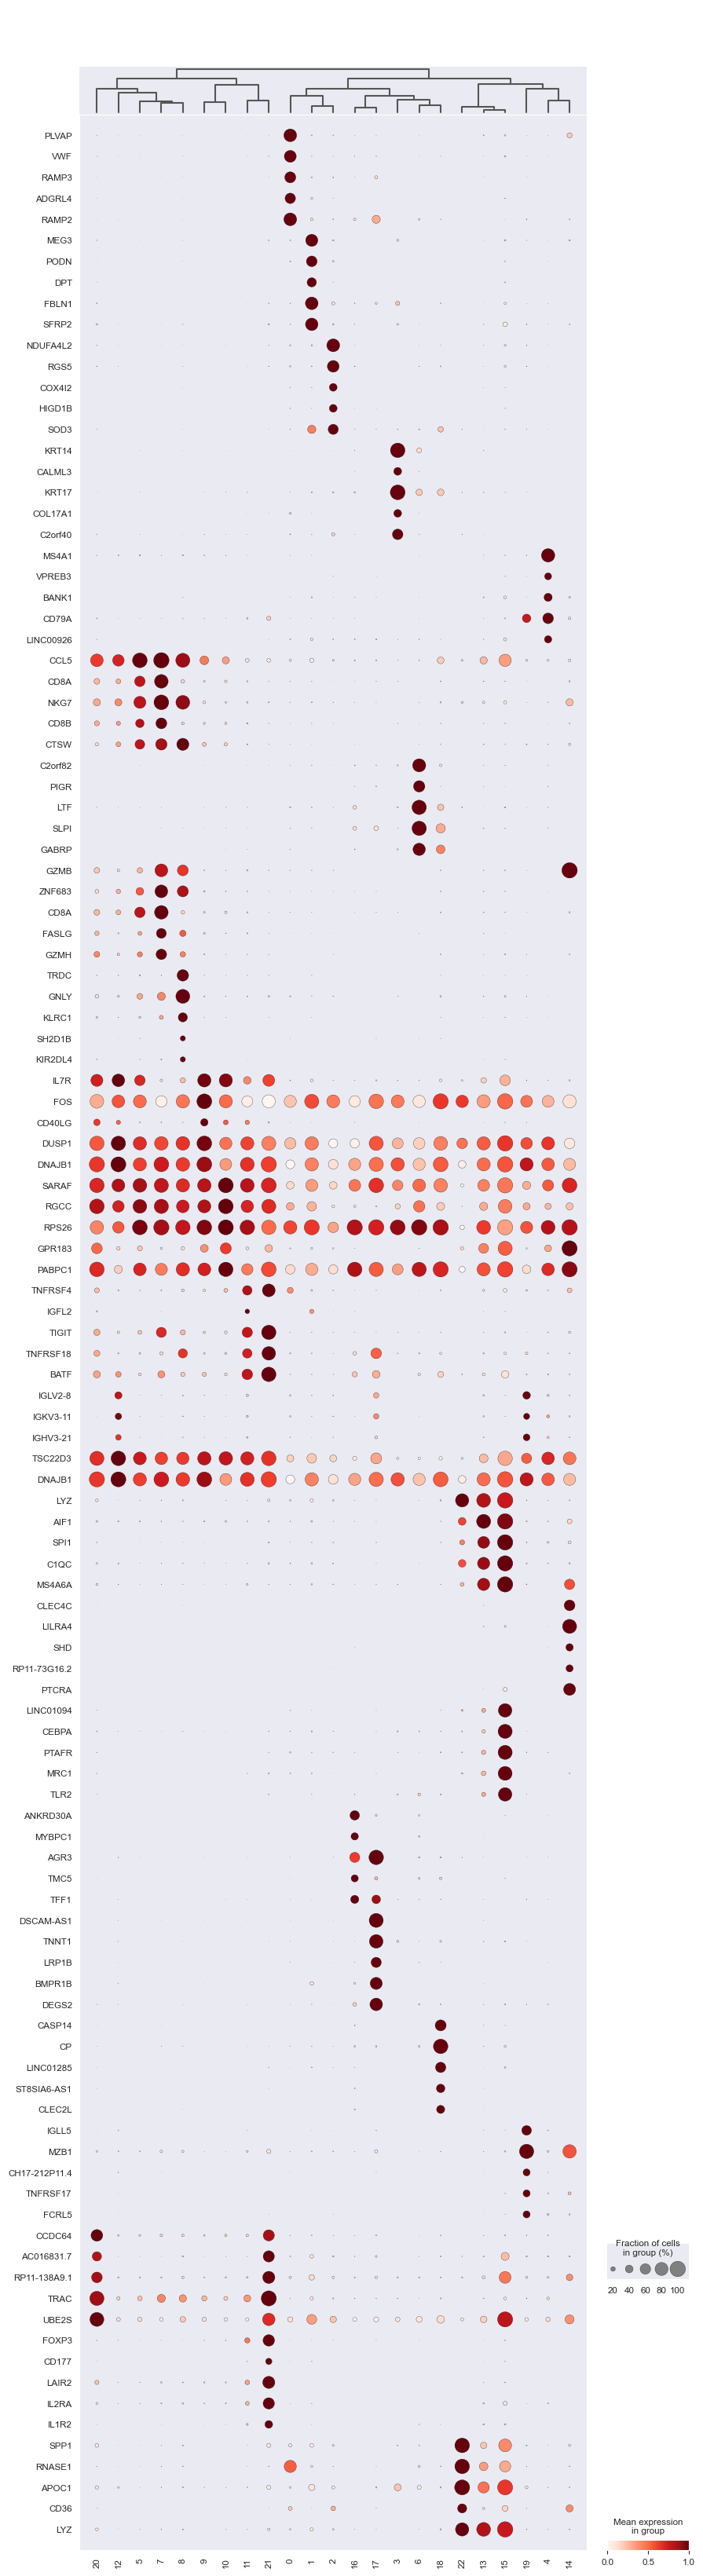

In [20]:
sc.pl.dotplot(rna_for_de, marker_genes,
              groupby = 'leiden',
              dendrogram = True,
              standard_scale = 'var',
              swap_axes = True)

In [21]:
# alternate ranking of genes
sc.tl.rank_genes_groups(rna_for_de, 'leiden',
                        method = 'wilcoxon',
                        use_raw = use_raw,
                        key_added = 'wilcoxon_fixed',
                        pts = True,
                        min_in_group_fraction = 0.1,  # Require reasonable expression
                        min_fold_change = 1.5)  # Filter for stronger signals


/opt/anaconda3/envs/cite_seq/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/opt/anaconda3/envs/cite_seq/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/opt/anaconda3/envs/cite_seq/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:440: PerformanceWarning: DataF

The final part of the expression analysis is performing the neighbors clustering on the highly differentiated genes. What is nice about this is we get better subcluster resolution than against the whole data
Ultimately this is most useful for identifying any subclusters that have differentially expressed CDs that can be used for our MSI model prediction.

/var/folders/02/m7p_k0md7zqfxg14bky51rzr0000gn/T/ipykernel_63616/645468250.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(rna_filtered, resolution = 0.9)  # Lower resolution for finer subclustering


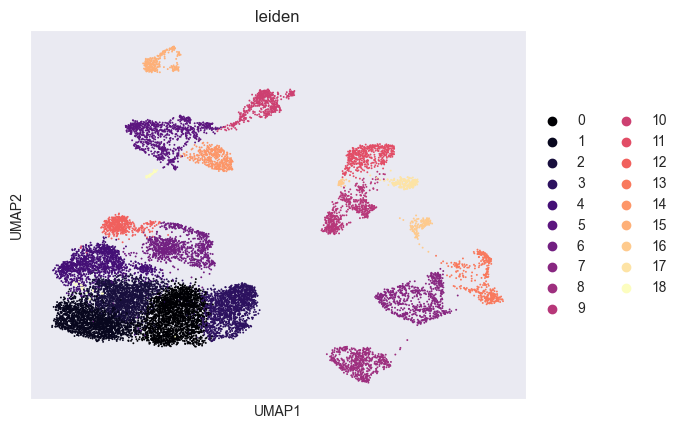

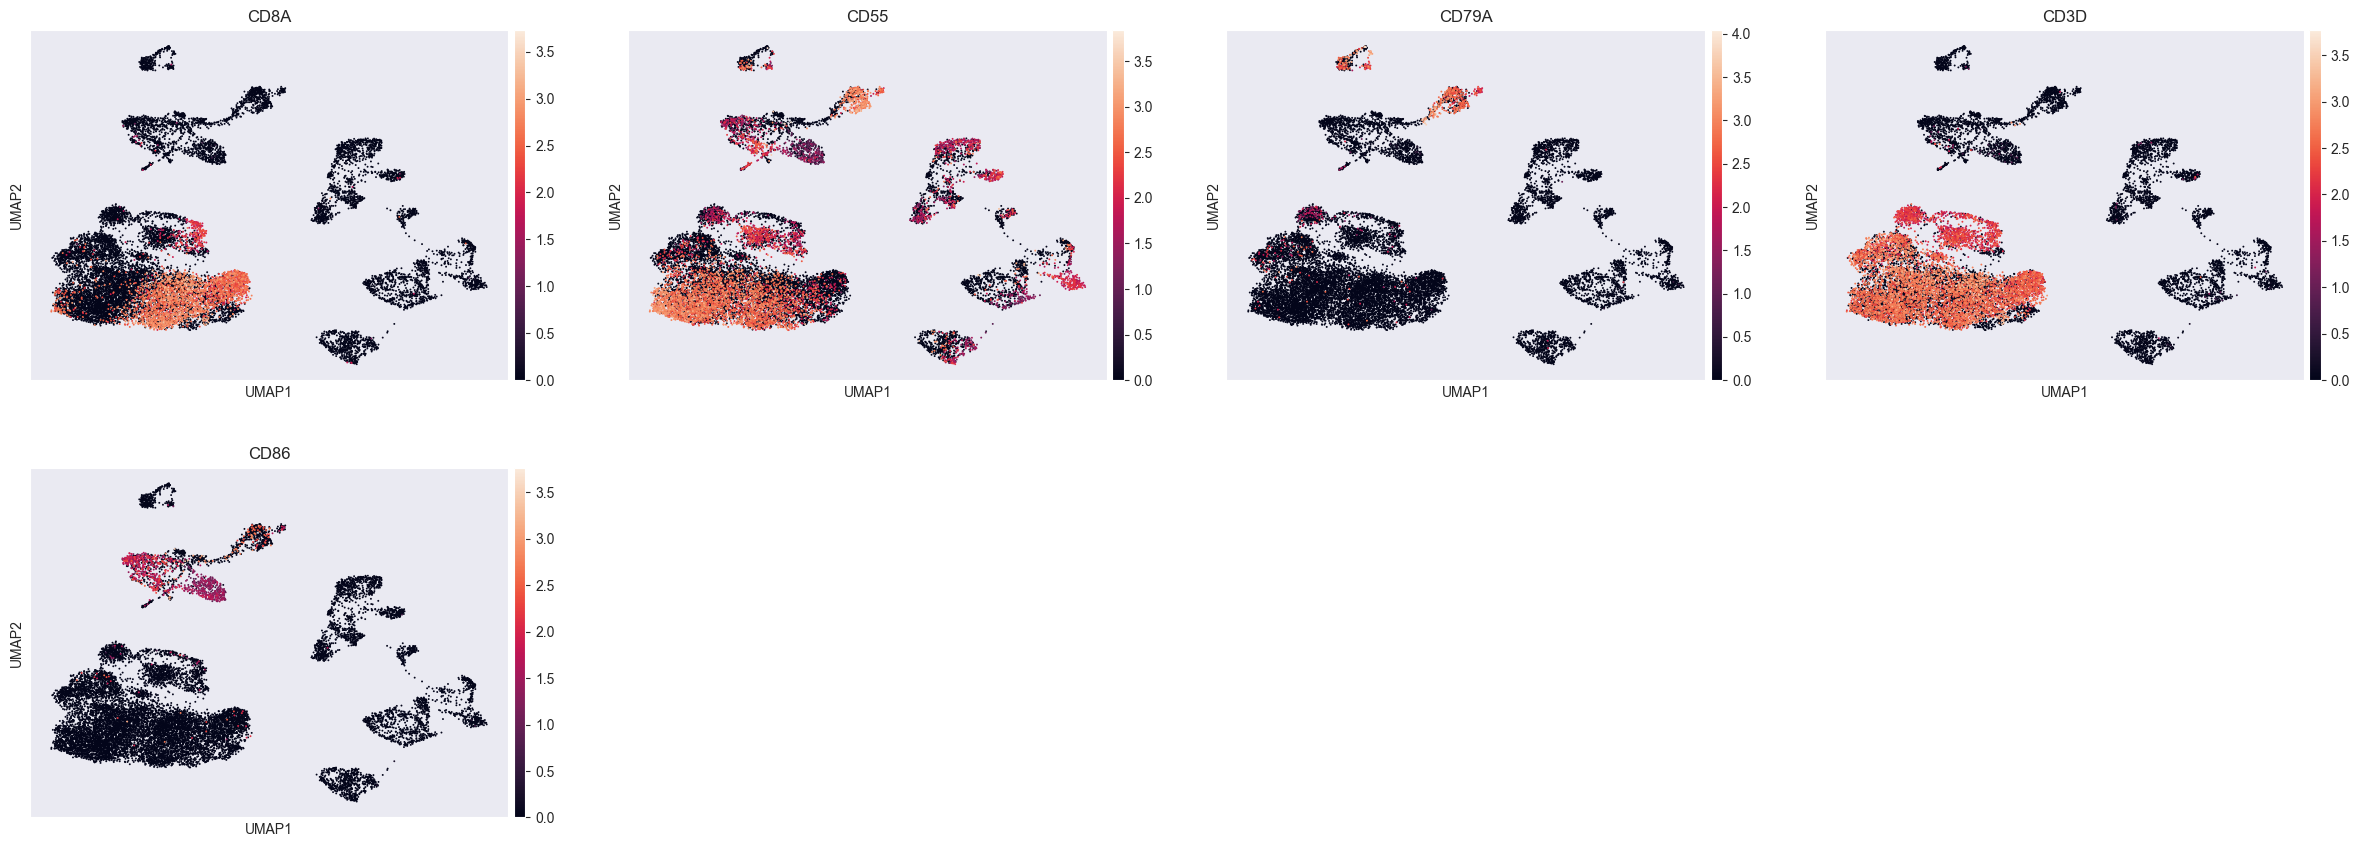

In [22]:
# Re-run analysis on this subset
sc.pp.neighbors(rna_filtered, n_neighbors = 15, n_pcs = 30)
sc.tl.leiden(rna_filtered, resolution = 0.9)  # Lower resolution for finer subclustering

sc.tl.umap(rna_filtered)
sc.pl.umap(rna_filtered, color = 'leiden', palette = 'magma')

# fill in more markers here
rna_markers = ['CD8A', 'CD55', 'CD79A', 'CD271', 'CD3D', 'CD86']
markers_in_data = [m for m in rna_markers if m in rna_filtered.var_names]
sc.pl.umap(rna_filtered, color = markers_in_data)

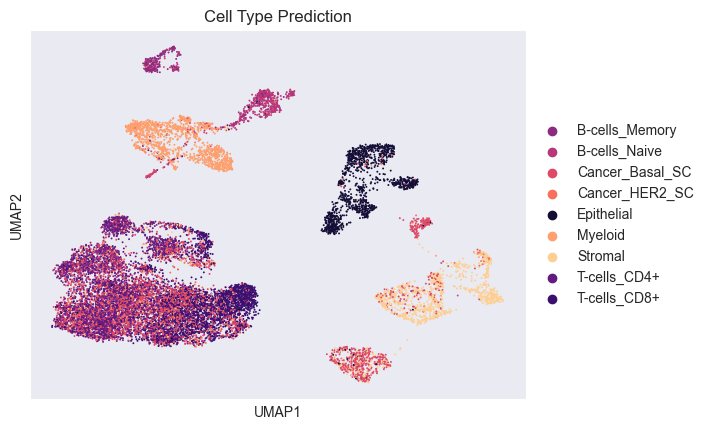

In [23]:
cell_markers = {
    'Epithelial'     : ['KRT18', 'KRT19', 'EPCAM', 'KRT8', 'CDH1', 'MUC1'],
    'T-cells_CD8+'   : ['CD3D', 'CD8A', 'CD8B', 'GZMA', 'PRF1', 'GZMB', 'TBX21'],
    'T-cells_CD4+'   : ['CD3D', 'CD4', 'IL7R', 'CXCR3', 'CCR4', 'CCR6'],
    'B-cells_Memory' : ['CD79A', 'MS4A1', 'CD27', 'CD80', 'CD86', 'IGHG1'],
    'B-cells_Naive'  : ['CD79A', 'MS4A1', 'IgD', 'CD38lo', 'CD27-', 'IGHM'],
    'Cancer_Basal_SC': ['CD271', 'p63', 'KRT5', 'KRT17', 'VIM', 'ITGA1'],
    'Cancer_HER2_SC' : ['CD44', 'CD24-', 'ALDH1', 'ERBB2', 'EGR1', 'MUC1'],
    'Myeloid'        : ['CD14', 'LYZ', 'CSF1R', 'CD11b', 'CD11c', 'CD16', 'HLA-DR'],
    'Stromal'        : ['COL1A1', 'FAP', 'ACTA2', 'PDGFRA', 'PDGFRB', 'VIM', 'CXCL12']
}


# cell type scores
for cell_type, markers in cell_markers.items():
    markers_in_data = [m for m in markers if m in rna_filtered.var_names]
    if markers_in_data:
        sc.tl.score_genes(rna_filtered, markers_in_data, score_name = f'{cell_type}_score')

# predicted cell type
cell_type_columns = [f'{ct}_score' for ct in cell_markers.keys() if f'{ct}_score' in rna_filtered.obs.columns]
rna_filtered.obs['predicted_celltype'] = rna_filtered.obs[cell_type_columns].idxmax(axis = 1)
rna_filtered.obs['predicted_celltype'] = rna_filtered.obs['predicted_celltype'].str.replace('_score', '')

# Create a custom color palette for cell types
c = sns.color_palette("magma", n_colors = len(cell_markers.keys()), desat = 1)
celltype_colors = dict(zip(cell_markers.keys(), c))

# Plot a single UMAP with cell types as colors
sc.pl.umap(rna_filtered,
           color = 'predicted_celltype',
           palette = celltype_colors,
           title = 'Cell Type Prediction')

Predicting MSI is the main feature of this code. We can subset the rna_filtered adata frame to more specifically score the individual cells based on their expression of a few marker genes.


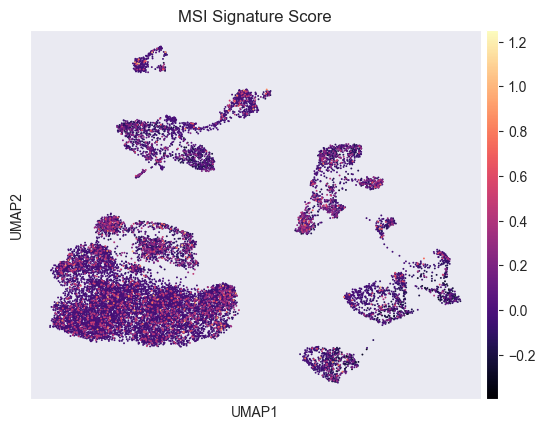

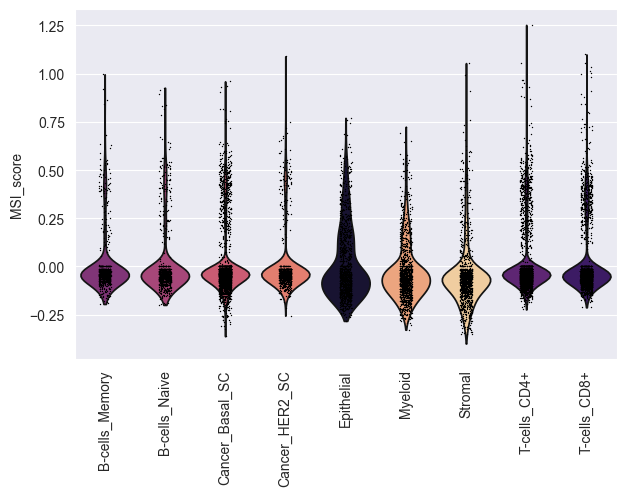

In [24]:
msi_genes = ['WRN', 'MLH1', 'MSH2', 'MSH6', 'PMS2']
sc.tl.score_genes(rna_filtered, msi_genes, score_name = 'MSI_score')

sc.pl.umap(rna_filtered,
           color = 'MSI_score',
           color_map = 'magma',
           title = 'MSI Signature Score')
sc.pl.violin(rna_filtered, 'MSI_score', groupby = 'predicted_celltype', rotation = 90, palette = celltype_colors, hue = 'predicted_celltype')

The Tumor microenvironment (TME) is made up a variety of components including extracellular matrix, cells that are not malignant (such as immune and stromal cells) and cancer cells.
Characterizing the TME is individualized to a patient as this makeup can be fairly heterogeneous from patient to patient. There are immune checkpoint inhibitors (ICI) and CAR-T therapies that respond better to patients with a certain tumor make-up. 

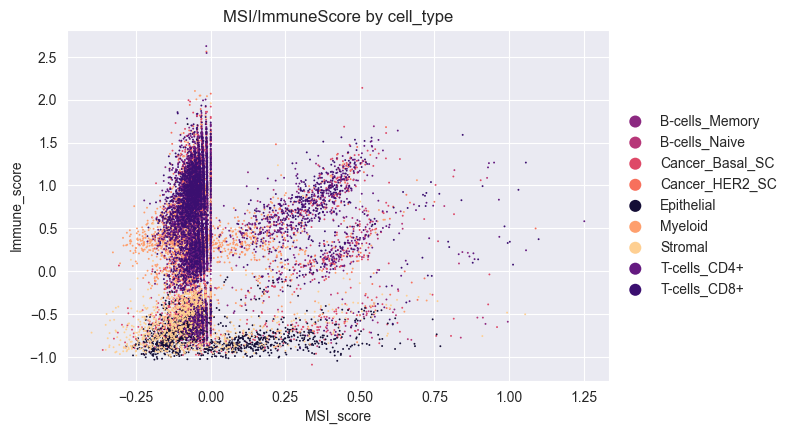

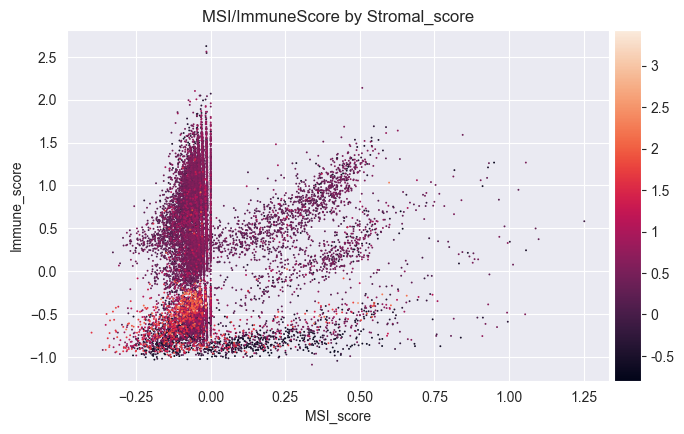

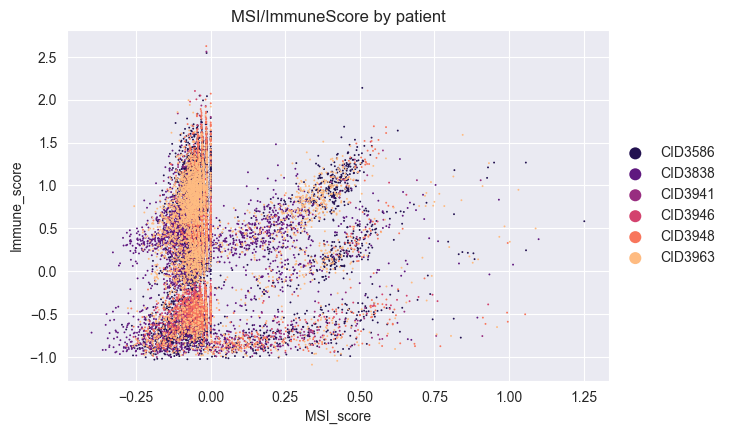

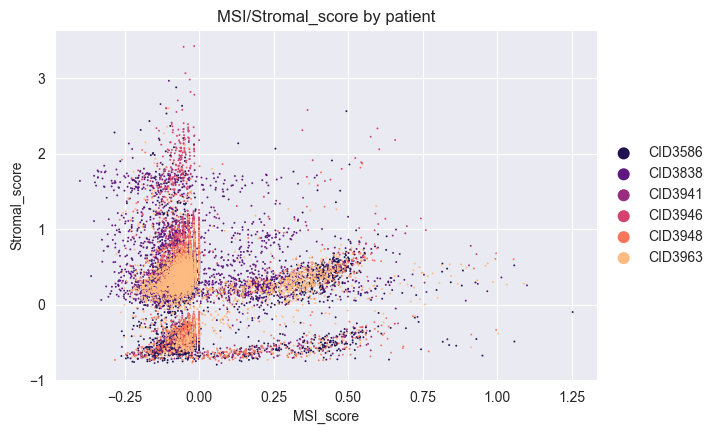

In [25]:
p_categories = rna_filtered.obs['patient'].cat.categories
c = sns.color_palette("magma", n_colors=len(p_categories))
patient_colors = dict(zip(p_categories, c))
    
# MSI correlates with immune infiltration
immune_markers = ['CD8A', 'IFNG', 'GZMA', 'PRF1', 'IDO1', 'CXCL9', 'CXCL10']
sc.tl.score_genes(rna_filtered, immune_markers, score_name = 'immune_score')
rna_filtered.uns['patient_colors'] = list(patient_colors.values()) 

# Compare MSI with stromal/immune components
tme_markers = {'Immune' : ['PTPRC', 'CD3E', 'CD68'],
               'Stromal': ['COL1A1', 'VIM', 'FAP']}

for tme, markers in tme_markers.items():
    markers_in_data = [m for m in markers if m in rna_filtered.var_names]
    if markers_in_data:
        sc.tl.score_genes(rna_filtered, markers_in_data, score_name = f'{tme}_score')

sc.pl.scatter(rna_filtered, x = 'MSI_score', y = 'Immune_score', color = 'predicted_celltype', title = 'MSI/ImmuneScore by cell_type')
sc.pl.scatter(rna_filtered, x = 'MSI_score', y = 'Immune_score', color = 'Stromal_score', title = 'MSI/ImmuneScore by Stromal_score')
sc.pl.scatter(rna_filtered, x = 'MSI_score', y = 'Immune_score', color = 'patient', title = 'MSI/ImmuneScore by patient')
sc.pl.scatter(rna_filtered, x = 'MSI_score', y = 'Stromal_score', color = 'patient', title = 'MSI/Stromal_score by patient')

/opt/anaconda3/envs/cite_seq/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1150: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], c=palette[label], label=label)


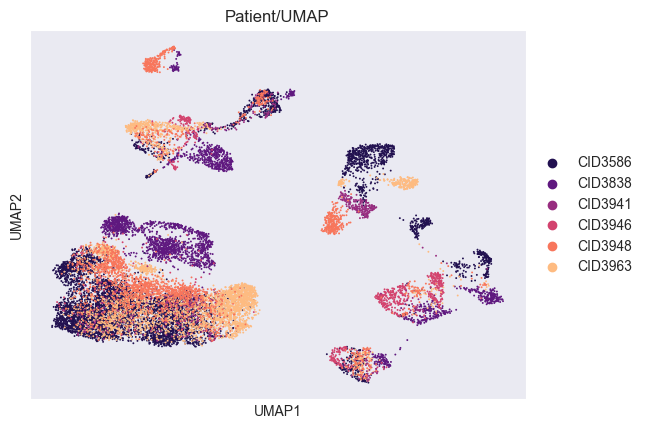

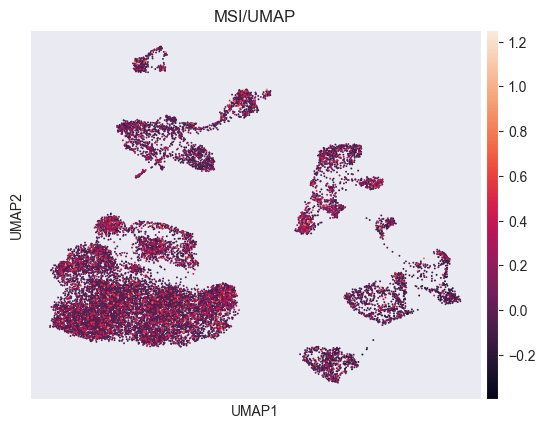

In [27]:
# Additional UMAP plots
sc.pl.umap(rna_filtered, color = 'patient', title = "Patient/UMAP")
sc.pl.umap(rna_filtered, color = 'MSI_score', title = "MSI/UMAP")

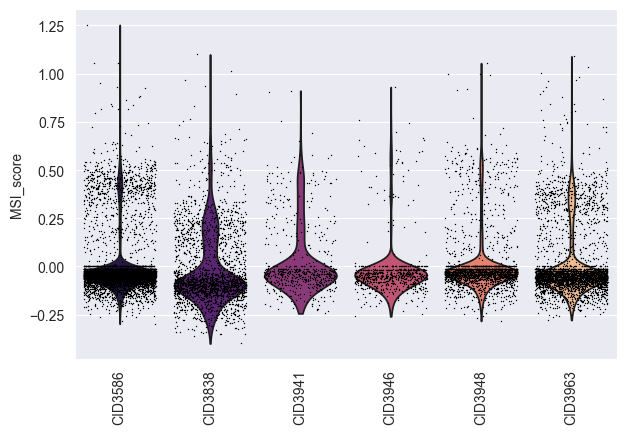

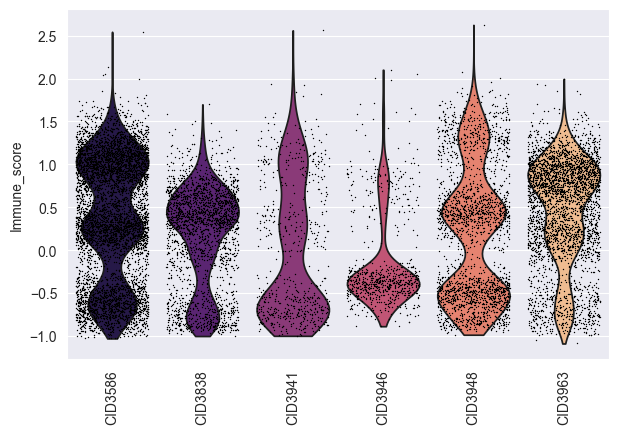

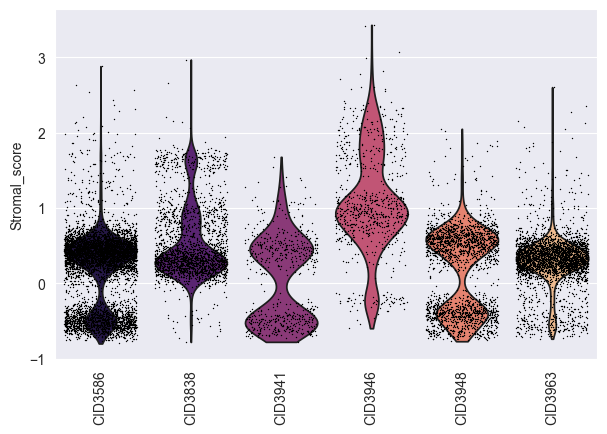

In [28]:
# Violin plots
sc.pl.violin(rna_filtered,
             'MSI_score',
             color = patient_colors,
             groupby = 'patient',
             stripplot = True,
             jitter = .4,
             rotation = 90)
sc.pl.violin(rna_filtered, 'Immune_score',
             color = patient_colors,
             groupby = 'patient',
             stripplot = True,
             jitter = .4,
             rotation = 90)
sc.pl.violin(rna_filtered, 'Stromal_score',
             color = patient_colors,
             groupby = 'patient',
             stripplot = True,
             jitter = .4,
             rotation = 90)

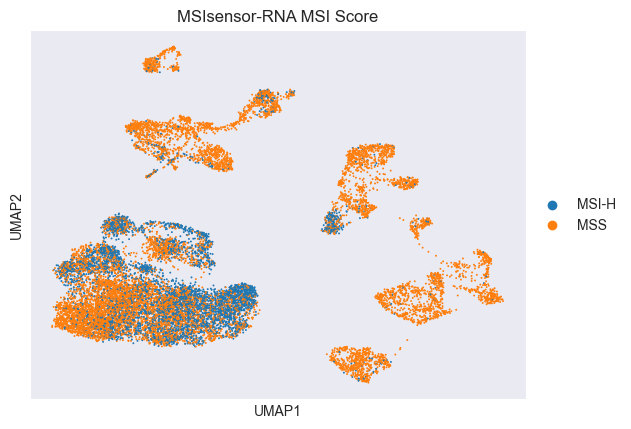

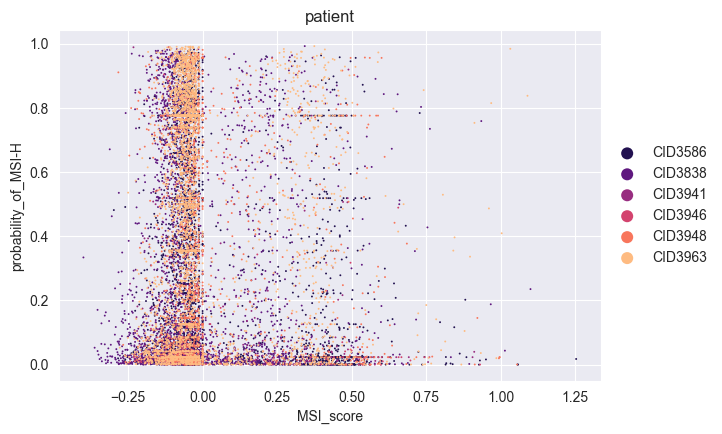

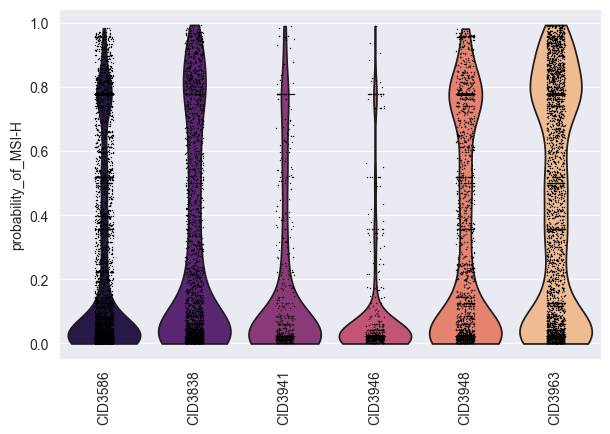

In [35]:
# Visualize MSIsensor predictions
sc.pl.umap(rna_filtered, color='msi_status', 
           color_map='magma', 
           title='MSIsensor-RNA MSI Score')

# Compare with your gene signature-based score
sc.pl.scatter(rna_filtered, 
              x='MSI_score',  # Your current score 
              y='probability_of_MSI-H',  # MSIsensor score
              color='patient')

# Analyze MSI status by cell type
sc.pl.violin(rna_filtered, 'probability_of_MSI-H', 
             groupby='patient', 
             rotation=90, 
             color = patient_colors)

# # Patient-level MSI status based on cell aggregation
# patient_msi = rna_filtered.obs.groupby('patient')['MSIsensor_score'].mean().sort_values(ascending=False)
# fig, ax = plt.subplots(figsize=(12, 5))
# sns.barplot(x=patient_msi.index, y=patient_msi.values, ax=ax)
# plt.title('Patient-level MSI Score (MSIsensor-RNA)')
# plt.xticks(rotation=45)
# plt.tight_layout()